# PRAICP-1012-Pneumonia Chest X-ray Classification

## Objectives

**1.Image Processing**  
Apply Contrast Limited Adaptive Histogram Equalization (CLAHE) for image enhancement.  
  
**2. Modelling**  
Develop a deep learning model to classify chest X-ray images as Normal or Pneumonia.  
  
**Evaluation Metrics**: Recall, F1-Score, AUC  
**Dataset**: Chest X-Ray Images (Pneumonia)  

## Import Libraries

In [ ]:
# core libraries
import os
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
from PIL import Image


Build a DataFrame mapping each image file path to its class label across train/val/test splits for easy analysis and preprocessing

In [ ]:
def is_image_file(filename):
    return filename.lower().endswith((".png", ".jpg", ".jpeg"))

records = []

for split in ["train", "val", "test"]:
    for cls in ["NORMAL", "PNEUMONIA"]:
        folder = os.path.join("chest_xray", split, cls)
        for img in os.listdir(folder):
            if is_image_file(img):
                records.append({
                    "filepath": os.path.join(folder, img),
                    "label": cls
                })

df = pd.DataFrame(records)

### Visualize Class Samples

In [ ]:
def visualize_class_samples(df, class_name, n=5):
    subset = df[df["label"] == class_name].sample(n=n, random_state=8)

    plt.figure(figsize=(15, 3))
    for i, (_, row) in enumerate(subset.iterrows()):
        img = Image.open(row["filepath"]).convert("L")
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(class_name)
    plt.show()

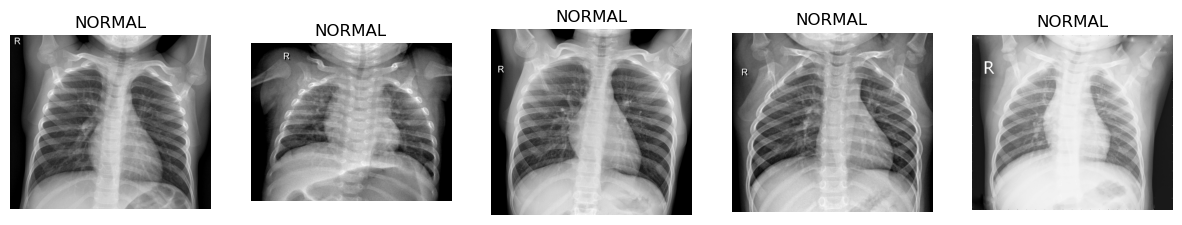

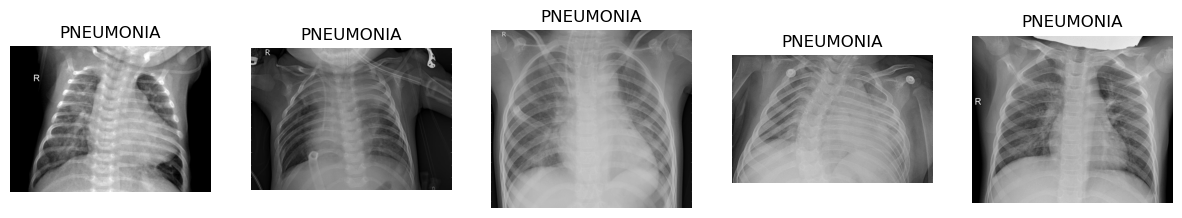

In [ ]:
visualize_class_samples(df, "NORMAL", n=5)
visualize_class_samples(df, "PNEUMONIA", n=5)

PNEUMONIA X-rays show cloudy white opacities and reduced contrast due to lung infection.

In [ ]:
df.shape

(5856, 2)

**The dataset contains 5856 x-ray images**

In [ ]:
df["label"].value_counts()


label
PNEUMONIA    4273
NORMAL       1583
Name: count, dtype: int64

**We have clear class imbalance, we may have to use data augmentation or class weighting.**

In [ ]:
pd.crosstab(
    index=df["label"],
    columns=[p.split(os.sep)[1] for p in df["filepath"]]
)


col_0,test,train,val
label,,,
NORMAL,234,1341,8
PNEUMONIA,390,3875,8


**Here, the validation split is wrong, becasuse it has only 8 images per class, making validation metrics unreilable. Validation set should have a reasonable fraction (≈10–20%) of training data, with class propotions similar to train/test.**  

The width, height and number of channels of images are recorded to understand image dimension varibility and channel consistency

In [ ]:
import numpy as np
from PIL import Image
from tqdm import tqdm

widths = []
heights = []
channels = []

for path in tqdm(df["filepath"]):
    img = Image.open(path)
    widths.append(img.size[0])   # width
    heights.append(img.size[1])  # height

    img_arr = np.array(img)
    if img_arr.ndim == 2:
        channels.append(1)
    else:
        channels.append(img_arr.shape[-1])


100%|████████████████████████████████████████████████████████████████████████| 5856/5856 [01:20<00:00, 72.51it/s]


In [ ]:
import pandas as pd

size_df = pd.DataFrame({
    "width": widths,
    "height": heights,
    "channels": channels
})

size_df.describe()


,width,height,channels
count,5856.000000,5856.000000,5856.000000
mean,1327.880806,970.689037,1.096653
std,363.500922,383.392117,0.428947
min,384.000000,127.000000,1.000000
25%,1056.000000,688.000000,1.000000
50%,1281.000000,888.000000,1.000000
75%,1560.000000,1187.000000,1.000000
max,2916.000000,2713.000000,3.000000


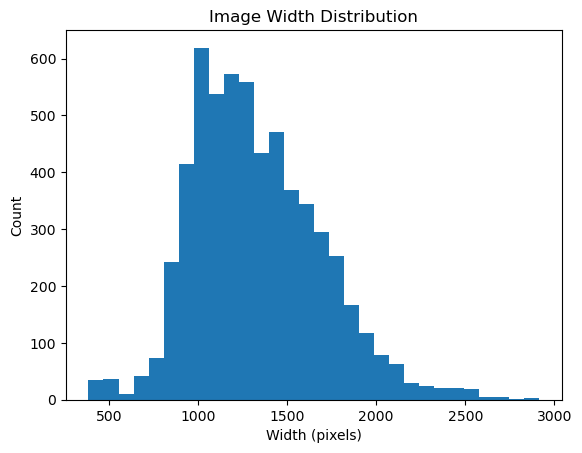

In [ ]:
import matplotlib.pyplot as plt

plt.hist(size_df["width"], bins=30)
plt.title("Image Width Distribution")
plt.xlabel("Width (pixels)")
plt.ylabel("Count")
plt.show()

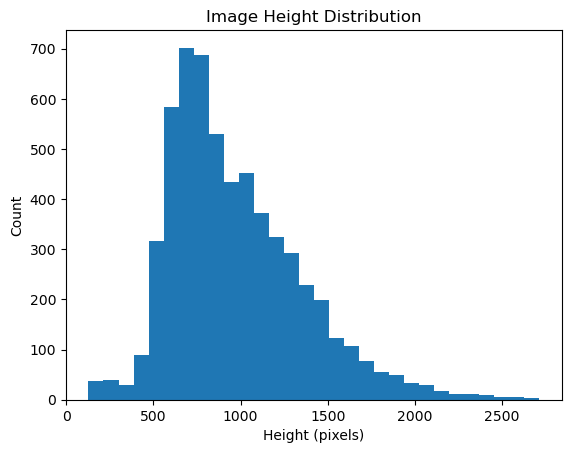

In [ ]:
plt.hist(size_df["height"], bins=30)
plt.title("Image Height Distribution")
plt.xlabel("Height (pixels)")
plt.ylabel("Count")
plt.show()


The image have highly variable resolutions with a right-skewed distribution. This doesn't hurt performance because all images are resized to a fixed input lenght

In [ ]:
size_df["channels"].value_counts()


channels
1    5573
3     283
Name: count, dtype: int64

Although, we have 1-chanel and 3-channel images, all of them will get converted to 3-channel before feeding to the model.

## Train-Validation-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["label"],
    random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["label"],
    random_state=RANDOM_SEED
)

In [ ]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(4099, 2)
(879, 2)
(878, 2)


In [ ]:
print("Train:\n", train_df["label"].value_counts())
print("\nValidation:\n", val_df["label"].value_counts())
print("\nTest:\n", test_df["label"].value_counts())

Train:
 label
PNEUMONIA    2991
NORMAL       1108
Name: count, dtype: int64

Validation:
 label
PNEUMONIA    641
NORMAL       237
Name: count, dtype: int64

Test:
 label
PNEUMONIA    641
NORMAL       238
Name: count, dtype: int64


The split creates a 70% train, 15% validation, and 15% test split (stratified by class labels). The real data split has not happened yet, that happens based on this dataframe splits we have created.

In [ ]:
train_df.to_csv("train_split.csv", index=False)
val_df.to_csv("val_split.csv", index=False)
test_df.to_csv("test_split.csv", index=False)

The above code saves the finalized train, validation, and tests splits to CSV files so the same data partitions be used

#### Create clean output folder structure

In [ ]:
import os

BASE_OUT = "chest_xray_clean"
SPLITS = ["train", "val", "test"]
CLASSES = ["NORMAL", "PNEUMONIA"]

for split in SPLITS:
    for cls in CLASSES:
        os.makedirs(os.path.join(BASE_OUT, split, cls), exist_ok=True)

#### Copying images into train/val/split folder structures based in the CSV splits, organizing them by class for model training.

In [ ]:
import shutil
from tqdm import tqdm

def copy_split(df_split, split_name):
    for _, row in tqdm(df_split.iterrows(), total=len(df_split)):
        src = row["filepath"]
        label = row["label"]
        dst = os.path.join(BASE_OUT, split_name, label, os.path.basename(src))
        shutil.copy(src, dst)

copy_split(train_df, "train")
copy_split(val_df, "val")
copy_split(test_df, "test")

100%|█████████████████████████████████████████████████████████████████████████| 879/879 [00:02<00:00, 301.22it/s]


#### Verifying the number of images per class in each train/validation/test split

In [ ]:
import os
BASE_OUT = "chest_xray_clean"
SPLITS = ["train", "val", "test"]
CLASSES = ["NORMAL", "PNEUMONIA"]

for split in SPLITS:
    print(f"\n{split.upper()}")
    for cls in CLASSES:
        path = os.path.join(BASE_OUT, split, cls)
        print(cls, ":", len(os.listdir(path)))


TRAIN
NORMAL : 1108
PNEUMONIA : 2991

VAL
NORMAL : 237
PNEUMONIA : 641

TEST
NORMAL : 238
PNEUMONIA : 641


## CLAHE (Contrast Limited Adaptive Histogram Equalization)
CLAHE enhances local contrast and makes subtle pathological patterns more visible to the model.

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm

In [ ]:
def apply_clahe_pil(
    img_pil,
    clip_limit=2.0,
    tile_grid_size=(8, 8)
):
    """
    Apply CLAHE to a PIL image and return PIL image (3-channel RGB).
    """

    # Convert PIL → grayscale NumPy
    img_gray = np.array(img_pil.convert("L"))

    clahe = cv2.createCLAHE(
        clipLimit=clip_limit,
        tileGridSize=tile_grid_size
    )

    img_clahe = clahe.apply(img_gray)

    # Convert back to 3-channel RGB
    img_rgb = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)

    return Image.fromarray(img_rgb)


#### Create clean output folder structure for image after applying CLAHE

In [ ]:
INPUT_ROOT = "chest_xray_clean"
OUTPUT_ROOT = "chest_xray_clahe"

splits = ["train", "val", "test"]
classes = ["NORMAL", "PNEUMONIA"]

os.makedirs(OUTPUT_ROOT, exist_ok=True)

#### Applies CLAHE to every image in each train/val/test class folder and saves the processed images into a mirrored directory structure.

In [ ]:
for split in splits:
    for cls in classes:
        input_dir = os.path.join(INPUT_ROOT, split, cls)
        output_dir = os.path.join(OUTPUT_ROOT, split, cls)

        os.makedirs(output_dir, exist_ok=True)

        for img_name in tqdm(
            os.listdir(input_dir),
            desc=f"{split}/{cls}"
        ):
            # Skip hidden/system files
            if img_name.startswith("."):
                continue

            img_path = os.path.join(input_dir, img_name)

            try:
                img = Image.open(img_path)
                clahe_img = apply_clahe_pil(img)

                clahe_img.save(os.path.join(output_dir, img_name))

            except Exception as e:
                print(f"Failed on {img_path}: {e}")


test/PNEUMONIA: 100%|██████████████████████████████████████████████████████████| 641/641 [00:38<00:00, 16.86it/s]


#### Side-by-side comparison of a chest X-ray image before and after applying CLAHE

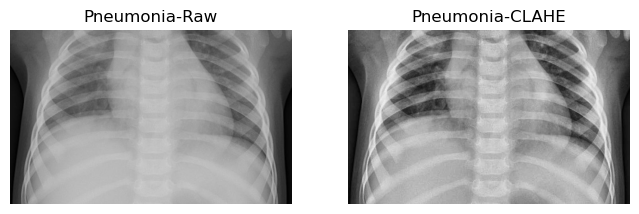

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

# Paths
img_clean_path = "chest_xray_clean/train/pneumonia/person1_bacteria_1.jpeg"
img_clahe_path = "chest_xray_clahe/train/pneumonia/person1_bacteria_1.jpeg"

# Load images
img_clean = Image.open(img_clean_path).convert("RGB")
img_clahe = Image.open(img_clahe_path).convert("RGB")

# Plot
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_clean)
plt.title("Pneumonia-Raw")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_clahe)
plt.title("Pneumonia-CLAHE")
plt.axis("off")

plt.show()


#### Verifying the number of images per class in each train/validation/test split after CLAHE

In [ ]:
import os
BASE_OUT = "chest_xray_clahe"
SPLITS = ["train", "val", "test"]
CLASSES = ["NORMAL", "PNEUMONIA"]

for split in SPLITS:
    print(f"\n{split.upper()}")
    for cls in CLASSES:
        path = os.path.join(BASE_OUT, split, cls)
        print(cls, ":", len(os.listdir(path)))


TRAIN
NORMAL : 1108
PNEUMONIA : 2991

VAL
NORMAL : 237
PNEUMONIA : 641

TEST
NORMAL : 238
PNEUMONIA : 641


#### Creates a ZIP archive of the chest_xray_clahe folder to upload to google drive and use it inside colab

In [ ]:
import shutil

shutil.make_archive(
    base_name="chest_xray_clahe",
    format="zip",
    root_dir=".",
    base_dir="chest_xray_clahe"
)

'C:\\Users\\wwwsa\\OneDrive\\Desktop\\PRAICP-1012-ChestXRay\\chest_xray_clahe.zip'

So far we have worked on jupyter notebook, but we will do training on colab to take advantage of GPUs.

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------

#### Mounts Google Drive to the Colab environment so you can access its files.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Extracts the chest_xray_clahe.zip file from Google Drive into the /content/ directory.

In [2]:
!unzip /content/drive/MyDrive/chest_xray_clahe.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/chest_xray_clahe/test/PNEUMONIA/person937_virus_1599.jpeg  
  inflating: /content/chest_xray_clahe/test/PNEUMONIA/person940_virus_1604.jpeg  
  inflating: /content/chest_xray_clahe/test/PNEUMONIA/person940_virus_1609.jpeg  
  inflating: /content/chest_xray_clahe/test/PNEUMONIA/person944_bacteria_2869.jpeg  
  inflating: /content/chest_xray_clahe/test/PNEUMONIA/person94_bacteria_457.jpeg  
  inflating: /content/chest_xray_clahe/test/PNEUMONIA/person94_bacteria_458.jpeg  
  inflating: /content/chest_xray_clahe/test/PNEUMONIA/person952_bacteria_2877.jpeg  
  inflating: /content/chest_xray_clahe/test/PNEUMONIA/person958_bacteria_2883.jpeg  
  inflating: /content/chest_xray_clahe/test/PNEUMONIA/person958_virus_1630.jpeg  
  inflating: /content/chest_xray_clahe/test/PNEUMONIA/person95_bacteria_463.jpeg  
  inflating: /content/chest_xray_clahe/test/PNEUMONIA/person966_virus_1639.jpeg  
  inflating: /content/chest_xray_cl

#### Verifying the number of images per class in each train/validation/test split after extraction

In [3]:
import os
for split in ["train", "val", "test"]:
    for cls in ["NORMAL", "PNEUMONIA"]:
        path = f"/content/chest_xray_clahe/{split}/{cls}"
        print(split, cls, len(os.listdir(path)))

train NORMAL 1108
train PNEUMONIA 2991
val NORMAL 237
val PNEUMONIA 641
test NORMAL 238
test PNEUMONIA 641


### Image Augmentation
Image augmentaion is employed to improve model generalization by increasing data diversity and reducing overfitting on a limited dataset.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])


we intentionally selected mild geometric augmentations that preserve medical relevance while increasing variability.
Augmentations that could distort anatomical structure (e.g., vertical flips or heavy rotations) were deliberately avoided.

#### Visualising random augmentaions on same image

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
IMG_SIZE = (224, 224)

img_path = "chest_xray_clahe/train/PNEUMONIA/person1001_bacteria_2932.jpeg"  
img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
img = tf.keras.utils.img_to_array(img)
img = tf.expand_dims(img, axis=0)  # shape: (1, H, W, 3)


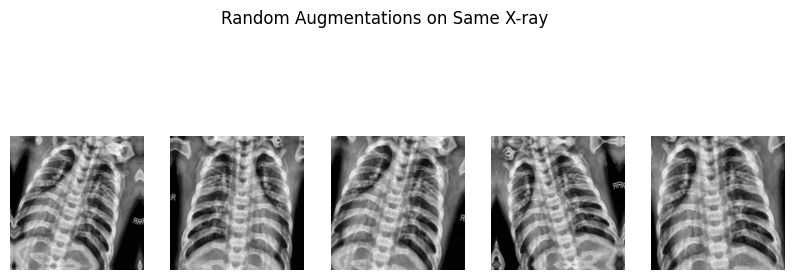

In [ ]:
plt.figure(figsize=(10, 4))

for i in range(5):
    augmented = data_augmentation(img, training=True)

    plt.subplot(1, 5, i + 1)
    plt.imshow(augmented[0].numpy().astype("uint8"))
    plt.axis("off")

plt.suptitle("Random Augmentations on Same X-ray")
plt.show()

## Training - ResNet50V2
Transfer learning based approach is used to leverage features learned from large-scale datasets (imagenet) , reducing training time and data requirements.
ResNet50V2 is chosen for its residual connections, which enable stable training of deep networks.

#### Imports

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#### Defines image dimensions, batch size, reproducibility seed, and dataset directory paths

In [5]:
# config
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

TRAIN_DIR = "chest_xray_clahe/train"
VAL_DIR   = "chest_xray_clahe/val"
TEST_DIR  = "chest_xray_clahe/test"


#### Creates batched TensorFlow datasets for training, validation, and testing from directory-structured images. Resizing happens here.

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=False
)


Found 4099 files belonging to 2 classes.
Found 878 files belonging to 2 classes.
Found 879 files belonging to 2 classes.


Enables asynchronous data prefetching to improve input pipeline performance during training and evaluation.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

#### Defines an on-the-fly data augmentation pipeline with controlled flips, rotations, and zooms to improve model generalization.

In [8]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])


### Training Phase-1

#### Loads a pre-trained ResNet50V2 as a frozen feature extractor for initial transfer learning.

In [9]:
base_model = ResNet50V2(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)
# during training phase-1 only the classifier head weights gets updated
base_model.trainable = False 


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


#### Builds a transfer learning model with ResNet50V2, applying preprocessing, augmentation and classifier head.

In [10]:
inputs = layers.Input(shape=IMG_SIZE + (3,))

x = tf.keras.applications.resnet_v2.preprocess_input(inputs) 
#the above function scales pixel values from [0,255] to [-1,1]

x = data_augmentation(x)

x = base_model(x, training=False)

# classifier head
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)


#### Compiles the model with Adam optimizer, binary cross-entropy loss, and accuracy plus AUC metrics for evaluation.

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc")
    ]
)

#### Sets up early stopping to monitor validation AUC, stopping training if it doesn’t improve for 5 epochs and restoring the best weights.

In [12]:
early_stop_phase1 = EarlyStopping(
    monitor="val_auc",
    patience=5,
    mode="max",
    restore_best_weights=True
)

#### Trains the model for up to 30 epochs on the training set with validation, using early stopping to save the best weights.

In [13]:
history_phase1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop_phase1]
)

Epoch 1/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 44s 231ms/step - accuracy: 0.8254 - auc: 0.8956 - loss: 0.3953 - val_accuracy: 0.8747 - val_auc: 0.9819 - val_loss: 0.2568
Epoch 2/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 29s 225ms/step - accuracy: 0.9085 - auc: 0.9643 - loss: 0.2204 - val_accuracy: 0.9123 - val_auc: 0.9882 - val_loss: 0.1896
Epoch 3/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 39s 211ms/step - accuracy: 0.9231 - auc: 0.9705 - loss: 0.1932 - val_accuracy: 0.9453 - val_auc: 0.9898 - val_loss: 0.1273
Epoch 4/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 28s 216ms/step - accuracy: 0.9231 - auc: 0.9724 - loss: 0.1921 - val_accuracy: 0.9556 - val_auc: 0.9904 - val_loss: 0.1137
Epoch 5/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 27s 211ms/step - accuracy: 0.9229 - auc: 0.9698 - loss: 0.2008 - val_accuracy: 0.9510 - val_auc: 0.9889 - val_loss: 0.1155
Epoch 6/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 27s 211ms/step - accuracy: 0.9260 - auc: 0.9743 - loss: 0.1916 - val_accuracy: 0.9658 - val_auc: 0.9916 - val_loss: 0.1058
Epoch 7/30
129/129 ━━━

#### Plots training and validation loss and AUC curves over epochs to visualize model performance.

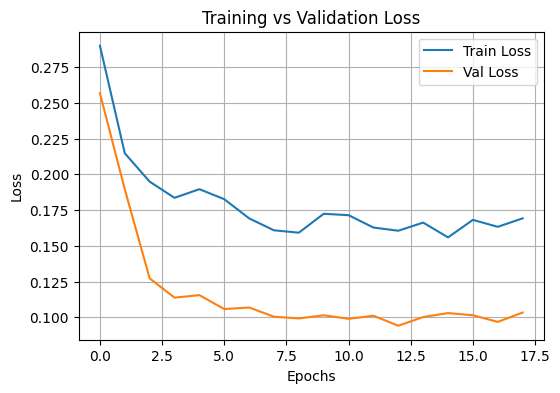

In [16]:
plt.figure(figsize=(6,4))
plt.plot(history_phase1.history["loss"], label="Train Loss")
plt.plot(history_phase1.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

The graph looks a bit unusual because the validation loss is consistently lower than the training loss, which can happen with strong regularization, dropout, or small batch effects.
Insight: The model is not overfitting, and it generalizes well to validation data, though the training loss might benefit from slightly longer training or learning rate adjustment.

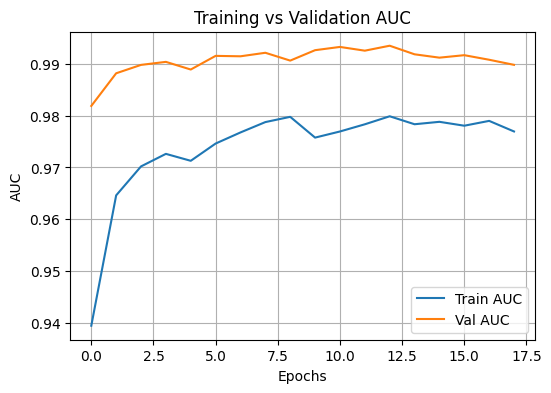

In [17]:
plt.figure(figsize=(6,4))
plt.plot(history_phase1.history["auc"], label="Train AUC")
plt.plot(history_phase1.history["val_auc"], label="Val AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.title("Training vs Validation AUC")
plt.legend()
plt.grid(True)
plt.show()

The model generalizes extremely well, achieving near-perfect discrimination on validation data, while training performance is slightly lower due to regularization effects.

### Training Phase-2 (Fine Tuning)

#### Unfreezes the last 40 layers of base_model so their weights can get updated during training

In [18]:
for layer in base_model.layers[-40:]:
    layer.trainable = True

#### Compiles the model with Adam optimizer, binary cross-entropy loss, and accuracy plus AUC metrics for evaluation. With a lower learning rate.

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc")
    ]
)

#### Sets up callbacks to stop training early if val_auc stops improving for 7 epochs and to reduce the learning rate by 70% if val_auc plateaus for 3 epochs.

In [20]:
early_stop_phase2 = EarlyStopping(
    monitor="val_auc",
    patience=7,
    mode="max",
    restore_best_weights=True
)

lr_decay = ReduceLROnPlateau(
    monitor="val_auc",
    factor=0.3,
    patience=3,
    min_lr=1e-6,
    mode="max",
    verbose=1
)

#### Trains model for up to 40 epochs by applying early stopping and learning rate reduction callbacks.

In [21]:
history_phase2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=[early_stop_phase2, lr_decay]
)

Epoch 1/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 44s 241ms/step - accuracy: 0.8739 - auc: 0.9438 - loss: 0.3143 - val_accuracy: 0.9442 - val_auc: 0.9889 - val_loss: 0.1388 - learning_rate: 1.0000e-05
Epoch 2/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 29s 227ms/step - accuracy: 0.9236 - auc: 0.9717 - loss: 0.1974 - val_accuracy: 0.9556 - val_auc: 0.9886 - val_loss: 0.1145 - learning_rate: 1.0000e-05
Epoch 3/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 30s 230ms/step - accuracy: 0.9296 - auc: 0.9780 - loss: 0.1701 - val_accuracy: 0.9590 - val_auc: 0.9874 - val_loss: 0.1169 - learning_rate: 1.0000e-05
Epoch 4/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 42s 235ms/step - accuracy: 0.9469 - auc: 0.9850 - loss: 0.1368 - val_accuracy: 0.9601 - val_auc: 0.9903 - val_loss: 0.1153 - learning_rate: 1.0000e-05
Epoch 5/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 30s 232ms/step - accuracy: 0.9416 - auc: 0.9830 - loss: 0.1488 - val_accuracy: 0.9613 - val_auc: 0.9908 - val_loss: 0.1065 - learning_rate: 1.0000e-05
Epoch 6/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 45s 2

#### Plots training and validation loss and AUC curves over epochs to visualize model performance.

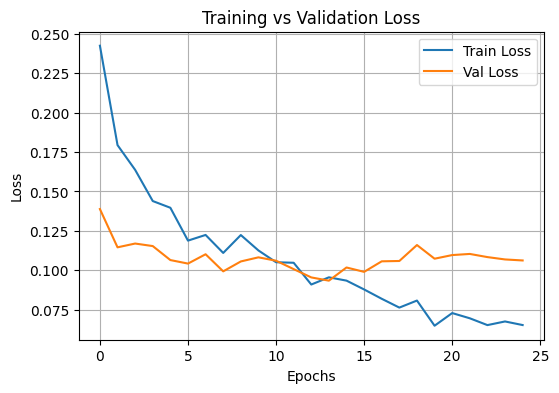

In [23]:
plt.figure(figsize=(6,4))
plt.plot(history_phase2.history["loss"], label="Train Loss")
plt.plot(history_phase2.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

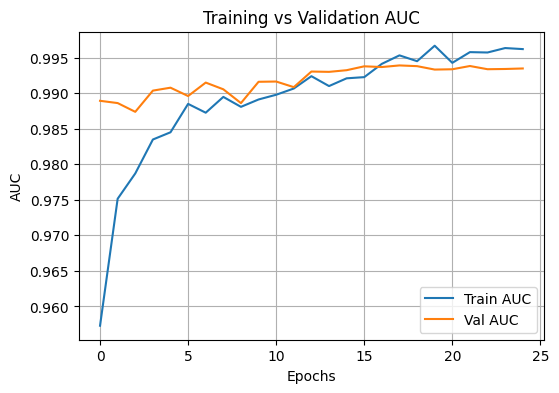

In [24]:
plt.figure(figsize=(6,4))
plt.plot(history_phase2.history["auc"], label="Train AUC")
plt.plot(history_phase2.history["val_auc"], label="Val AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.title("Training vs Validation AUC")
plt.legend()
plt.grid(True)
plt.show()

Validation AUC plateaus around ~0.993 after ~15 epochs while tracking train AUC closely, indicating good generalization with no severe overfitting in terms of class separation.  The final model weights were restored from the 18th epoch, where validation AUC was at its peak before subsequent epochs showed no meaningful improvement.

#### Generates test-set predictions, applies a 0.5 decision threshold, and collects the true labels for evaluation.

In [25]:
import numpy as np

# Predict probabilities
y_probs = model.predict(test_ds)

# Convert to class labels
y_pred = (y_probs > 0.5).astype(int).ravel()

# True labels
# Collect true labels from each batch in test_ds into a single 1-D array for evaluation
y_true = np.concatenate([y for x, y in test_ds], axis=0)


28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 238ms/step


### Classification Report

In [27]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=["NORMAL", "PNEUMONIA"]
))

              precision    recall  f1-score   support

      NORMAL       0.86      0.94      0.90       238
   PNEUMONIA       0.98      0.95      0.96       641

    accuracy                           0.94       879
   macro avg       0.92      0.94      0.93       879
weighted avg       0.95      0.94      0.94       879



Threshold tuning is important here because it allows prioritizing pneumonia recall

## Threshold Tuning (using validation set)

#### Extracts predicted probabilities from the model and flattens them, then concatenates all true labels from the validation dataset into a single array for evaluation.

In [7]:
import numpy as np
from sklearn.metrics import classification_report

# Get probabilities
y_probs = model.predict(val_ds).ravel()

# Get true labels
y_true = np.concatenate([y for _, y in val_ds], axis=0)


28/28 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step


#### Evaluates how different probability thresholds trade off pneumonia recall vs precision to select an optimal decision threshold.

In [8]:
thresholds = np.arange(0, 0.6, 0.025)

results = []

for t in thresholds:
    y_pred = (y_probs >= t).astype(int)

    report = classification_report(
        y_true,
        y_pred,
        target_names=["NORMAL", "PNEUMONIA"],
        output_dict=True,
        zero_division=0
    )

    pneu_recall = report["PNEUMONIA"]["recall"]
    pneu_precision = report["PNEUMONIA"]["precision"]

    results.append((t, pneu_recall, pneu_precision))

    print(
        f"Threshold={t:.2f} | "
        f"Pneumonia Recall={pneu_recall:.3f} | "
        f"Precision={pneu_precision:.3f}"
    )


Threshold=0.00 | Pneumonia Recall=1.000 | Precision=0.730
Threshold=0.03 | Pneumonia Recall=0.994 | Precision=0.951
Threshold=0.05 | Pneumonia Recall=0.994 | Precision=0.959
Threshold=0.08 | Pneumonia Recall=0.991 | Precision=0.967
Threshold=0.10 | Pneumonia Recall=0.991 | Precision=0.974
Threshold=0.12 | Pneumonia Recall=0.988 | Precision=0.974
Threshold=0.15 | Pneumonia Recall=0.986 | Precision=0.974
Threshold=0.18 | Pneumonia Recall=0.986 | Precision=0.975
Threshold=0.20 | Pneumonia Recall=0.986 | Precision=0.977
Threshold=0.23 | Pneumonia Recall=0.981 | Precision=0.981
Threshold=0.25 | Pneumonia Recall=0.980 | Precision=0.986
Threshold=0.28 | Pneumonia Recall=0.977 | Precision=0.986
Threshold=0.30 | Pneumonia Recall=0.975 | Precision=0.986
Threshold=0.33 | Pneumonia Recall=0.970 | Precision=0.986
Threshold=0.35 | Pneumonia Recall=0.970 | Precision=0.987
Threshold=0.38 | Pneumonia Recall=0.967 | Precision=0.989
Threshold=0.40 | Pneumonia Recall=0.964 | Precision=0.989
Threshold=0.43

#### Selecting the threshold that maintains at least 0.97 precision while maximizing recall.

In [9]:
# Constraint: precision >= 0.97
valid = [r for r in results if r[2] >= 0.97]

# From valid ones, choose the threshold with maximum recall
best_threshold = max(valid, key=lambda x: x[1])[0]

print("Chosen threshold (precision ≥ 0.97, max recall):", best_threshold)


Chosen threshold (precision ≥ 0.97, max recall): 0.1


#### Classification report after threshold tuning on validations set

In [10]:
y_pred_final = (y_probs >= best_threshold).astype(int)

print(
    classification_report(
        y_true,
        y_pred_final,
        target_names=["NORMAL", "PNEUMONIA"]
    )
)

              precision    recall  f1-score   support

      NORMAL       0.97      0.93      0.95       237
   PNEUMONIA       0.97      0.99      0.98       641

    accuracy                           0.97       878
   macro avg       0.97      0.96      0.97       878
weighted avg       0.97      0.97      0.97       878



#### Stores the chosen threshold in a JSON file for later inference.

In [11]:
import json

with open("threshold.json", "w") as f:
    json.dump({"threshold": float(best_threshold)}, f)

### Final classification Report (test set)

In [12]:
from sklearn.metrics import classification_report
import numpy as np

# Load final threshold
import json
with open("threshold.json") as f:
    threshold = json.load(f)["threshold"]

# Predict on TEST set (first and only time)
y_probs_test = model.predict(test_ds).ravel()

# True labels
y_true_test = np.concatenate([y for _, y in test_ds], axis=0)

# Apply FINAL threshold
y_pred_test = (y_probs_test >= threshold).astype(int)

# FINAL report
print(
    classification_report(
        y_true_test,
        y_pred_test,
        target_names=["NORMAL", "PNEUMONIA"]
    )
)


28/28 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step
              precision    recall  f1-score   support

      NORMAL       0.93      0.88      0.91       238
   PNEUMONIA       0.96      0.98      0.97       641

    accuracy                           0.95       879
   macro avg       0.94      0.93      0.94       879
weighted avg       0.95      0.95      0.95       879



The model effectively detects Pneumonia, achieving a high recall of 0.98, ensuring minimal missed cases. Overall accuracy is 95%, with strong precision and F1-scores for both classes, highlighting reliable classification.

### Saving the model

In [28]:
model.save("resnet50v2_pneumonia_model.keras")

### Single-Image Inference code

In [73]:
import numpy as np
import cv2
import tensorflow as tf
from PIL import Image
import json

# ---------- Load model ----------
model = tf.keras.models.load_model("resnet50v2_pneumonia_model.keras")

# ---------- Load threshold ----------
with open("threshold.json", "r") as f:
    THRESHOLD = json.load(f)["threshold"]

# ---------- CLAHE preprocessing ----------
def apply_clahe_pil(img_pil, clip_limit=2.0, tile_grid_size=(8, 8)):
    img_gray = np.array(img_pil.convert("L"))
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    img_clahe = clahe.apply(img_gray)
    img_rgb = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)
    return Image.fromarray(img_rgb)

# ---------- Single image inference ----------
def predict_single_image(img_path):
    img = Image.open(img_path)
    img = apply_clahe_pil(img)
    img = img.resize(img_size)

    img_arr = np.expand_dims(np.array(img), axis=0)  # NO resize / NO scaling

    prob = model.predict(img_arr)[0][0]
    label = "PNEUMONIA" if prob >= THRESHOLD else "NORMAL"

    return {
        "prediction": label,
        "probability": float(prob),
        "threshold": THRESHOLD
    }



In [76]:
# ---------- Example ----------
result = predict_single_image("chest_xray_clean/test/pneumonia/person1_virus_12.jpeg")
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
{'prediction': 'PNEUMONIA', 'probability': 0.9999997615814209, 'threshold': 0.1}


### Challenges Faced  

The original dataset had an improper train/validation/test split, which was corrected by creating a dataframe-based split with stratification. 

Implemented CLAHE in preprocessing to enhances local contrast and makes subtle pathological patterns more visible to the model.  

Training was initially done on Jupyter Notebook, but due to computational constraints, the workflow had to be migrated to Google Colab to leverage GPU acceleration.  

A custom two-phase training strategy was designed, incorporating early stopping and learning rate decay to balance convergence and overfitting during fine-tuning.  

Threshold tuning introduced additional complexity, as model evaluation had to move beyond the default 0.5 cutoff to optimize recall–precision trade-offs for a medical task.  

Grad-CAM interpretability was attempted but failed and could not be finalized due to architectural and layer-access issues in the fine-tuned model.  


### Future Work

Future work can focus on incorporating larger and more diverse datasets, including images from different age groups, genders, and geographic regions, to enhance the model’s generalizability and robustness.  

Although a ResNet-based transfer learning approach was used, experimenting with more advanced architectures such as EfficientNet, DenseNet, or attention-based CNNs may yield better feature extraction and classification accuracy.  

Attempts to implement Grad-CAM for visual explanations were made but failed. Future work could focus on improving model interpretability using Grad-CAM providing clinicians with clearer insights into model predictions. 

Future work could include deploying the model as a web API using FastAPI to enable real-time Pneumonia detection from chest X-ray images in clinical applications



---------------------------------------------------------------

-------------------------------------------------------------------